In [ ]:
# !pip install seaborn

In [101]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x_bounds = (0, 50)
y_bounds = (0, 30)

In [117]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = None

class RRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start[0], start[1])
        self.node_g = Node(goal[0], goal[1])
        self.env = env
        self.n_iters = n_iters
        # CHECK IF START NODE AND GOAL NODE IN THE ENV......
        self.step = step
        self.prob_gs = prob_gs # Empirical value
        self.utils = Utils()
        self.node_s.cost = 0
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//10 # Empirical value
        self.trav_map = np.clip(np.random.normal(3, 8, size = (50, 30)), 2, 100)

    
    def planning(self):
        ax = sns.heatmap(self.trav_map.T, linewidth=0.5)
        plt.show()
        for iter in range(self.n_iters):

            if iter % 500 == 0:
                print(iter)

            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)
            if not self.utils.is_collision(n_nearest, n_new):
                # Steer!!! + Obstacles!!!
                N_near = self.compute_NN(n_new, near = True)
                n_min, cost_min = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
        path = [[self.node_g.x, self.node_g.y]]
        goal_state = self.get_goal_state()

        tot_path = self.compute_path(path, goal_state)
     

        self.plotting.animation(self.Tree, tot_path, "rrt*, N = " + str(self.n_iters))




    def choose_parent(self, N_near, n_nearest, n_new):
        n_parent = n_nearest
        cost_min = n_nearest.cost + self.compute_cost(n_nearest, n_new) # Init. guess parent for sampled node

        for n_near in N_near:
            # Compute Trajectory control HERE!!!
            # Collision CHECK!!!
            if not self.utils.is_collision(n_near, n_new):
                inter_cost = n_near.cost + self.compute_cost(n_near, n_new) # Intermediate cost
                if n_new.cost != None:
                    if inter_cost < n_new.cost and inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost
                else:
                    if inter_cost < cost_min:
                        n_parent = n_near         # New best alternative
                        cost_min = inter_cost
        
        return n_parent, cost_min

    def rewire(self, N_near, n_parent, n_new):
        
        for n_near in N_near:
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue
            # Steer!!!
            # Obstacle!!!
            if not self.utils.is_collision(n_near, n_new):
                if n_new.cost + self.compute_cost(n_near, n_new) < n_near.cost:
                    n_near_old_idx = self.Tree.index(n_near)
                    n_near.parent = n_new
                    n_near.cost = n_new.cost + self.compute_cost(n_near, n_new)
                    self.Tree[n_near_old_idx] = n_near
        return
    
    def compute_NN(self, n_curr, near = False):
        
        # CHECK COLLISION
        dist_list = np.array([self.compute_dist(n_curr, n_tree) for n_tree in self.Tree])
        
        if not near: # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)

            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)
            n_new = Node(n_nearest.x + dist*math.cos(theta), n_nearest.y + dist*math.sin(theta))
            
            return n_nearest, n_new 
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(len(dist_list)) if dist_list[idx] < self.radius]
            
            return node_list
    
    
    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            # print(x_new, y_new)
            return Node(x_new, y_new)
        
        return self.node_g

    def get_goal_state(self):

        dist_list = np.array([self.compute_dist(node, self.node_g) for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]
        
        return goal_state

    def compute_path(self, path, goal_state):

        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr.x, n_curr.y])
            n_curr = n_curr.parent 
        path.append([n_curr.x, n_curr.y])

        return path
    
    def compute_dist(self, n1, n2):

        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y - n2.y)**2)

        return dist
    
    def compute_cost(self, n1, n2):
        # Add Traversability!!!

        n1_trav = self.trav_map[int(n1.x), int(n1.y)] # Elevation on the real map
        n2_trav = self.trav_map[int(n2.x), int(n2.y)]
        
        increm = n2_trav - n1_trav # Elevation between the two points
        plan_dist = self.compute_dist(n1, n2) # Planar distance

        
        cost = math.sqrt(plan_dist**2 + increm**2)
        # cost = self.compute_dist(n1, n2)
        
        
        return cost
    
    

        




In [118]:
start = 2, 2
goal = 45, 25
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)
prob_gs = 0.1
n_iters = 1000
step = 10

rrt = RRT_STAR(start, goal, env, step, prob_gs, n_iters)

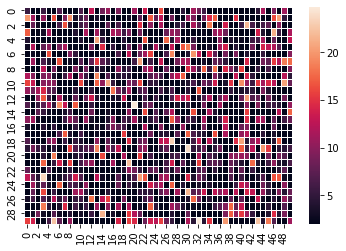

0
500


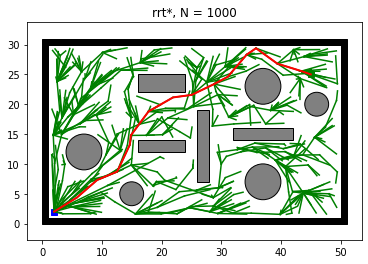

In [119]:
rrt.planning()

In [ ]:
N_near = [n_nearest, n1, n2]

In [8]:
def get_key(el):

    return el[0]

l = [(30, 1), (20, 2), (5, 4), (10,11)]
idx_min(l, key = get_key)


(5, 4)

In [ ]:
rrt.rewire(N_near, n1, n_new)

In [ ]:
rrt.Tree[1].cost

In [89]:
np.clip(np.random.normal(3, 1, size = (30, 50)), 0, 10)

array([[2.77952685, 2.34587721, 2.58542192, ..., 3.46067756, 2.41679018,
        4.44843464],
       [3.29843258, 2.9535215 , 2.71760168, ..., 2.38485116, 1.67587108,
        2.96043352],
       [2.10235456, 2.63892518, 1.38002193, ..., 3.76144618, 0.69321575,
        0.24621384],
       ...,
       [4.96680313, 2.81058999, 2.36895317, ..., 3.19331032, 3.48330797,
        3.12140231],
       [4.05210039, 4.72569205, 3.704484  , ..., 5.03792807, 4.028809  ,
        1.33753239],
       [2.85725463, 2.98661474, 2.77125505, ..., 2.95868284, 1.90177008,
        1.65398131]])